# Examples on using MTSDataModel

## Load modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,r'../src/')
import MTSDataModel as mts

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import rpy2

## Get data

In [4]:
filename = 'sample_data.csv'
colnames = {'level1': 'Variable', 'level2': 'Country', 'value': 'Value','index': 'Date'}
do = mts.MTSDataModel(filepath = filename, colnames = colnames)

In [5]:
df = do.ReturnDf()
df.head()

GDP                Inflation                       StockPrices  \
           DEU           FIN        AUT        DEU        FIN         AUT   
1970-01-01 NaN  6.355725e+10  25.154467  31.620100  12.784633   11.314692   
1970-04-01 NaN  6.568328e+10  25.412633  31.900933  12.861467   11.390358   
1970-07-01 NaN  6.706184e+10  25.781500  31.947800  12.946200   12.117531   
1970-10-01 NaN  6.790094e+10  26.002767  32.252033  13.017667   12.248969   
1971-01-01 NaN  6.437505e+10  26.260967  33.024367  13.290433   12.077389   

                                 
                  DEU       FIN  
1970-01-01  10.873145  1.247428  
1970-04-01   9.807037  1.306829  
1970-07-01   9.271091  1.348410  
1970-10-01   8.835394  1.401871  
1971-01-01   9.699077  1.490974

## Demonstate variable and entity selections
We'll demonstate how variables and entities are selected into methods that operate on the underlying data frame. The logic in other moethods is the same as in here with method GetVaribales() that just displays chosen variables.

In [6]:
# Get variable StockPrices for entities AUT, DEU, and FIN 
do.GetVariables(['StockPrices']).head(2)

StockPrices                     
                   AUT        DEU       FIN
1970-01-01   11.314692  10.873145  1.247428
1970-04-01   11.390358   9.807037  1.306829

In [7]:
# Get variable StockPrices and GDP by implicitly selecting entities.
# GDP not present for AUT, hence what will be returned are variables
# for DEU and FIN only!
do.GetVariables(['StockPrices','GDP']).head(2)

GDP               StockPrices          
           DEU           FIN         DEU       FIN
1970-01-01 NaN  6.355725e+10   10.873145  1.247428
1970-04-01 NaN  6.568328e+10    9.807037  1.306829

In [8]:
# When entity list is passed in explicitly, it is required that 
# inputted variables are present for all entities, If this is not
# the case, an error will be thrown.
do.GetVariables(['StockPrices','GDP'], entities=['FIN','AUT']).head(2)

MyException: VariablesCheck: Not all required variables present for AUT.

In [9]:
# Variables only for FIN.
do.GetVariables(['StockPrices','GDP','Inflation'], entities=['FIN']).head(2)

,GDP,Inflation,StockPrices
,FIN,FIN,FIN
1970-01-01,6.355725e+10,12.784633,1.247428
1970-04-01,6.568328e+10,12.861467,1.306829


In [10]:
# This will throw an error: variable Credit does not exist in data.
do.GetVariables(['Credit'])

MyException: EntitiesDefault: Not all variables present for given entities list.

## Pre-processing

### Deflate

In [11]:
# Defaltes variable StockPrices for al entities for which variables
# StockPrices and Inflation are present 
do.DeflateVariables(['StockPrices'], infvar = 'Inflation')
do.ReturnDf().head(2)

C:\Users\ville_000\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
../src\MTSDataModel.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame['X_hat'] = self.Deflate(frame)
C:\Users\ville_000\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).renam

GDP                Inflation                       StockPrices  \
           DEU           FIN        AUT        DEU        FIN         AUT   
1970-01-01 NaN  6.355725e+10  25.154467  31.620100  12.784633   11.314692   
1970-04-01 NaN  6.568328e+10  25.412633  31.900933  12.861467   11.390358   

                                StockPrices_def                       
                  DEU       FIN             AUT        DEU       FIN  
1970-01-01  10.873145  1.247428       11.314692  10.873145  1.247428  
1970-04-01   9.807037  1.306829       11.274643   9.720703  1.299022

### De-trend

In [12]:
# StockPrices_def available for AUT, DEU, and FIN. GDP available only DEU and FIN
# With below implicit selection varibales would get de-trended only for DEU and FIN.
#do.DetrendVariables(['StockPrices_def','GDP'], difftype = 'ld')

# This will result in error as GDP not available for AUT
#do.DetrendVariables(['StockPrices_def','GDP'], entities=['AUT','DEU','FIN'], difftype = 'ld')

# To de-trend StockPrices_def for AUT, DEU, and FIN as well as GDP for
# DEU and FIN. We can do two implicit entities selections:
do.DetrendVariables(['StockPrices_def'], dttype = 'ld1')
do.DetrendVariables(['GDP'], dttype = 'ld1')

# Simple logs
do.DetrendVariables(['GDP'], dttype = 'lg')

### HP filtering

In [13]:
do.HPFiltering(['GDP_lg'], lamb = 1600)
do.HPFiltering(['GDP_lg'], lamb = 1600, minobsamount = 40, expanding = 'expanding')

C:\Users\ville_000\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\ville_000\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


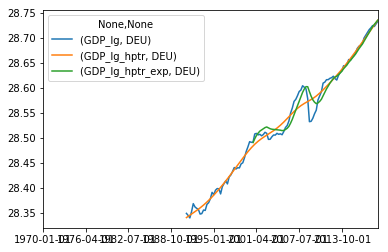

In [15]:
do.PlotVariables(['GDP_lg','GDP_lg_hptr','GDP_lg_hptr_exp'],['DEU'])

### Wavelet MRA decompositions

In [16]:
do.MRADecomposition(variables = ['StockPrices_def_ld1'], entities=['FIN'],levels = 6, minobsamount=40, expanding='expanding')
do.MRADecomposition(variables = ['StockPrices_def_ld1'], entities=['FIN'],levels = 6, minobsamount=40)

C:\Users\ville_000\Anaconda3\lib\site-packages\rpy2-2.9.4-py3.5-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\ville_000\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


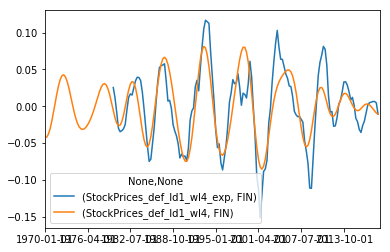

In [17]:
do.PlotVariables(['StockPrices_def_ld1_wl4','StockPrices_def_ld1_wl4_exp'],['FIN'])

### Dimension reduction

In [18]:
do.ReduceVariableDimension(suffix = 'PC', variables = ['StockPrices_def_ld1','GDP_ld1'] , entities = ['FIN','DEU'])

### Sum variables

In [19]:
variables = ['GDP_ld1','StockPrices_def_ld1']
do.SumVariables(variables,name="gdp+stock")

do.ReturnDf().head(2)

../src\MTSDataModel.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  crt_frame[name, entity] = crt_frame.sum(axis=1,skipna = False)


GDP                Inflation                       StockPrices  \
           DEU           FIN        AUT        DEU        FIN         AUT   
1970-01-01 NaN  6.355725e+10  25.154467  31.620100  12.784633   11.314692   
1970-04-01 NaN  6.568328e+10  25.412633  31.900933  12.861467   11.390358   

                                StockPrices_def             ...  \
                  DEU       FIN             AUT        DEU  ...   
1970-01-01  10.873145  1.247428       11.314692  10.873145  ...   
1970-04-01   9.807037  1.306829       11.274643   9.720703  ...   

           StockPrices_def_ld1_wl2 StockPrices_def_ld1_wl3  \
                               FIN                     FIN   
1970-01-01                     NaN                     NaN   
1970-04-01               -0.006748                0.029292   

           StockPrices_def_ld1_wl4 StockPrices_def_ld1_wl5  \
                               FIN                     FIN   
1970-01-01                     NaN                     NaN   
1970-04-01               -0.041935                0.044695   

           StockPrices_def_ld1_wl6 StockPrices_def_ld1_wl7        PC      \
                               FIN                     FIN       FIN DEU   
1970-01-01                     NaN                     NaN       NaN NaN   
1970-04-01                0.014795               -0.005337  0.029799 NaN   

           gdp+stock            
                 DEU       FIN  
1970-01-01       NaN       NaN  
1970-04-01       NaN  0.073432  

[2 rows x 44 columns]

## Plot

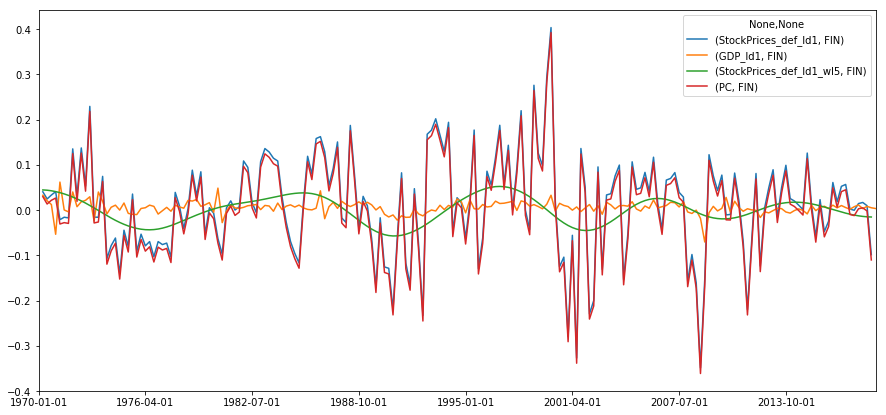

In [21]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
do.PlotVariables(variables=['StockPrices_def_ld1','GDP_ld1','PC','StockPrices_def_ld1_wl5'], entities=['FIN'], ax=ax)